In [38]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.notebook import tqdm


In [2]:
df = pd.read_csv('heart.csv')
df

,AGE_50,MD_50,SBP_50,DBP_50,HT_50,WT_50,CHOL_50,SES,CL_STATUS,MD_62,SBP_62,DBP_62,CHOL_62,WT_62,IHD_DX,DEATH
0,42,1,110,65,64,147,291,2,8,4,120,78,271,146,2,1
1,53,1,130,72,69,167,278,1,6,2,122,68,250,165,9,1
2,53,2,120,90,70,222,342,4,8,1,132,90,304,223,2,1
3,48,4,120,80,72,229,239,4,8,2,118,68,209,227,3,1
4,53,3,118,74,66,134,243,3,8,5,118,56,261,138,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,50,1,115,80,66,148,300,2,8,1,115,65,273,152,0,0
196,23,1,110,70,69,137,120,3,8,2,112,76,198,153,0,0
197,20,3,130,80,66,150,210,5,0,1,130,85,274,158,0,0
198,46,3,140,84,66,138,130,4,6,2,148,88,160,157,0,0


In [3]:
y = df['DEATH'].values.ravel()
X = df.drop('DEATH', axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

In [67]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [68]:
pred = knn.predict(X_test)
accuracy_score(y_test, pred)

0.6

A acurácia de 60% não é considerada boa em um problema de classificação binária: lembre-se que 50% de acurácia é equivalente ao que esperamos se a classificação for feita jogando uma moeda.

Neste sentido, a pergunta que queremos explorar é: a acurácia realmente é a métrica correta para avaliar o desempenho do classificador neste problema?

O objetivo real de um classificador treinado com a base *heart* é identificar pacientes que possivelmente podem morrer de problemas cardíacos. A acurácia nos diz apenas a proporção de pacientes que foram classificados corretamente, independente se realmente faleceram ou não de problemas cardíacos.

Para ter uma noção melhor dos acertos e erros do classificador considerando ambas as classes, podemos usar um dispositivo chamado de **Matriz de Confusão**.

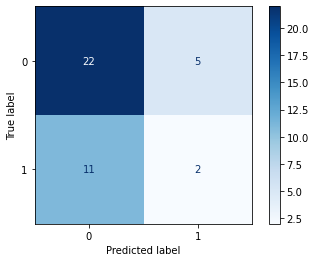

In [69]:
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues')

As células da matriz de confusão tem os seguintes significados:

<center>
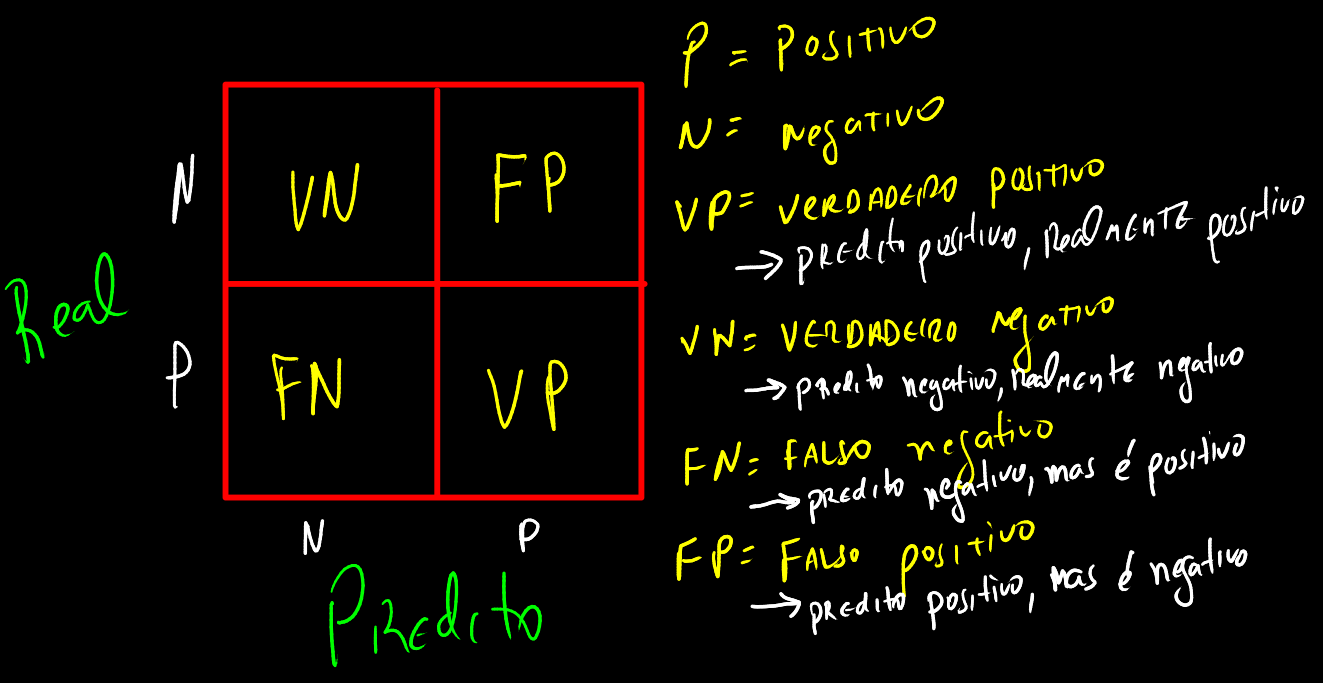
</center>

<!-- explicar como ler a matriz de confusão -->



A matriz de confusão resume o desempenho de um classificador de forma que é possível ter uma idéia da quantidade de acertos e dos tipos de erros cometidos. A partir da matriz de confusão podemos calcular várias métricas que nos permite avaliar se o desempenho do sistema é adequado para a aplicação.

## Precisão

Note que o classificador acertou 2 de 7 exemplos positivos. Ou seja, apenas 28% das predições que indicaram que o paciente morreu de problema cardíaco estavam corretas. Em outras palavras, podemos esperar que 28% dos pacientes com predições positivas realmente morrem de algum problema cardíaco. Esta taxa é muito baixa para ser usada na prática. O ideal é que TODAS as predições que apontem que o paciente provavelmente pode morrer verdadeiramente reflitam este risco. Esta métrica é chamada de precisão (*precision*) e é calculada por:

$$\text{Precisao} = \frac{vp}{vp + fp}$$

In [72]:
precision_score(y_test,pred)

0.2857142857142857

A precisão é uma métrica interessante pois ela é invariante ao desbalanceamento da base de dados pois ela é calculada apenas sobre a classe positiva. Uma base de dados é dita desbalanceada se o número de exemplos de todas as classes não é o mesmo. O número de exemplos de uma classe é chamado de *suporte* da classe.

In [73]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([109,  51]))

Note que o suporte da classe 0 é pouco mais que o dobro do suporte da classe 1 (nossa classe positiva). A métrica *acurácia* que usamos até agora é muito sensível ao balanceamento da base de dados. Por exemplo, considere uma base de dados com 100 exemplos em que apenas 1 exemplo é da classe positiva e o restante é da classe negativa. Se classificador sempre chutar que a classe é negativa, ele vai ter 99% de acurácia.

Como a precisão é invariante ao desbalanceamento, ela não tem este problema. No caso do exemplo, precisão será 0, uma vez que teríamos VP=0 e FP=100. Em relação ao classificador que desenvolvemos, veja que foram feitas muito mais predições para a classe negativa (coluna 0 da matriz de confusão) do que para a classe positiva (coluna 1 da matriz de confusão), confirmado o viés para a classe majoritária.

Um problema com a métrica precisão é que ela também pode assumir valores altos em um cenário claramente desfavorável.  Por exemplo, se apenas uma única predição for realizada para a classe positiva e esta predição estiver correta, a precisão será de 1 (também considerada como 100%), embora muitos exemplos verdadeiramente positivos podem ter sido classificados como negativos (chamamos estes erros de falsos negativos).

## *Recall*

Note que nosso classificador acertou apenas $\frac{2}{13}$ dos exemplos positivos! Ou seja, apenas 15% dos pacientes que morreram de algum problema cardíaco foram identificados pelo sistema. Como o objetivo deste classificador é detectar pessoas que correm risco de vida por problemas cardíacos, esta taxa mostra que o classificador não é bom o suficiente para ser usado na prática. O ideal seria que 100% dos pacientes que morreram de problemas cardíacos fossem classificados corretamente. Desta forma, com 100% de *recall*, se o sistema for usado para ajudar um médico podemos esperar que todos pacientes classificados como "mortos" pelo sistema realmente corram risco de vida. Esta métrica é chamada de *recall* é e calculada por:

$$\textit{Recall} = \frac{vp}{(vp + fn)}$$

Ou seja, o *recall* indica a capacidade do classificador encontrar todos os exemplos positivos. 

In [70]:
recall_score(y_test, pred)

0.15384615384615385

Recall resolve o problema relatado com a precisão, quando apenas uma única predição é realizada para a classe positiva e esta predição está correta. Neste caso, o acerto será contabilizado, mas todos os falsos negativos também refletirão na métrica, levando o *recall* a aproximadamente 0.

Um problema com a métrica *recall* é que ela também pode assumir valores altos em cenários claramente desfavoráveis. Por exemplo, se todas as predições sempre forem positivas, *recall* pode assumir o valor 1, mesmo classificando muitos exemplos negativos como positivos, ou seja, cometendo erros de falsos positivos. Na base de dados que estamos estudando, muitas pessoas que não tem risco algum de morrer de problemas cardíacos seriam classificados como correndo este risco.

## *F1-score* (F-measure)

Ambas métricas precisão e *recall* tem suas virtudes e defeitos. O mais importante é que estas métricas se complementam, ou seja, a "trapaça" para obter "bons" resultados na métrica precisão implica em valores baixos *para recall*, e vice-versa.

Neste contexto, vêm a dúvida: existe uma métrica que nos permite otimizar ambas precisão e *recall* ao mesmo tempo? Em outras palavras, é possível "combinar" em uma única métrica, a qualidade das predições (precisão) e a completude das predições (*recall*)?

A métrica F1-score combina ambas as qualidades das métricas precisão e *recall* em uma única métrica, definida pela média harmônica entre precisão e *recall*:

$$\text{F1-score} = \frac{2 \cdot \text{precisao} \cdot \textit{recall}}{\text{precisao} + \textit{recall}} = \frac{2 vp}{2vp + fp + fn}$$

A idéia é que, ao usar a média harmônica, o F1-score dá mais importância para a métrica constituinte (precisão ou *recall*) com valor mais baixo. Isto faz com que se os valores da precisão e o *recall* forem muito discrepantes, f1-score vai assumir um valor mais baixo. Isto faz com que esta métrica tenha um valor considerado alto apenas se ambas precisão e *recall* forem altas. Assim como precisão e *recall*, *F1-score* vai de 0 a 1, onde 0 é o o pior resultado possível e 1 é o melhor.

Desta forma, F1-score é uma métrica que sumariza as métricas precisão e *recall*, penalizando caso a discrepância entre ambas. F1-score é uma métrica amplamente utilizada para aferir o desempenho de classificadores binários e multi-classes.

In [76]:
f1_score(y_test, pred)

0.2

As métricas discutidas aqui não precisam ser calculadas apenas para a classe positiva. Elas também podem ser calculadas para a classe negativa (considerando-a como se fosse a classe positiva). Em classificação binária, o *Recall* da classe positiva também é conhecido como *sensibilidade* (*sensitivity*). Já o recall da classe negativa também é conhecido como *especificidade* (*specificity*).

A função ``classification_report`` calcula precisão, *recall* e *F1-score* por classe e apresenta os resultados em uma única tabela.

In [75]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73        27
           1       0.29      0.15      0.20        13

    accuracy                           0.60        40
   macro avg       0.48      0.48      0.47        40
weighted avg       0.54      0.60      0.56        40



As métricas discutidas aqui também podem ser calculadas classes arbitrárias em problemas de classificação multi-classe. No caso de problemas de classificação multi-classe, a classe de interesse é considerada como a classe positiva, e todas as outras são consideradas como negativas. Iremos explorar estas métricas em classificação multi-classe no futuro.